<a href="https://colab.research.google.com/github/Pengjp/gene_research/blob/master/5_6_k%3D10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import seaborn as sns, numpy as np
from scipy.stats import entropy
from scipy import stats
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand,randint
from numpy.random import randn, exponential
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape, Flatten
import matplotlib.pyplot as plt
from keras import optimizers
import tensorflow as tf
from numpy.random import random, choice
import warnings

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [0]:
# Ploting
sns.set()
def generate_gaps(k, theta=1e-4, rho=1e-5):
    'generate k gaps according to the genetic distribution'
    pos = 0
    gaps = []
    while True:
        x = np.random.exponential()
        while True:
            y = np.random.exponential() / (x * (theta + rho))  # segment height
            last_pos = pos
            pos += y
            if np.random.rand() < (theta / (theta + rho)): # mutation generated
                gaps.append(pos - last_pos)
                if len(gaps) == k:
                    return(gaps)
            else:  # recombination generated
                break

Epoch: 0
log score: -38.33907865742607


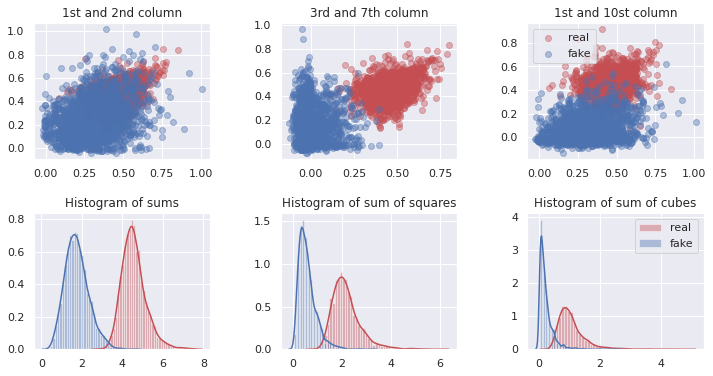

Epoch: 500
log score: -145.19306605738223


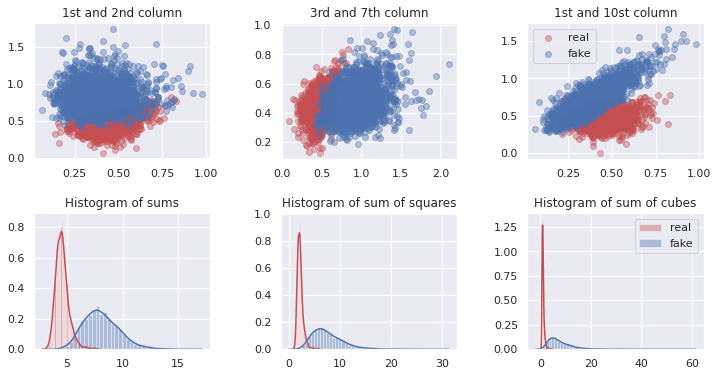

Epoch: 1000
log score: -45.277611432327916


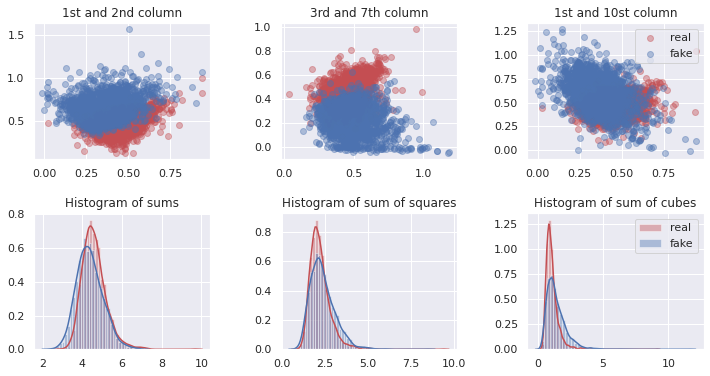

Epoch: 1500
log score: -1.4893417763452037


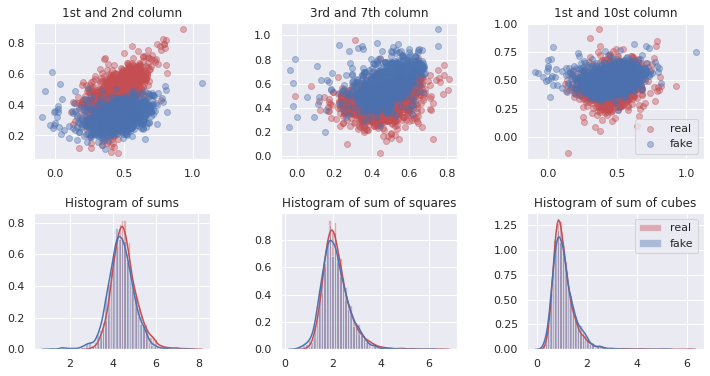

Epoch: 2000
log score: 6.953914395108432


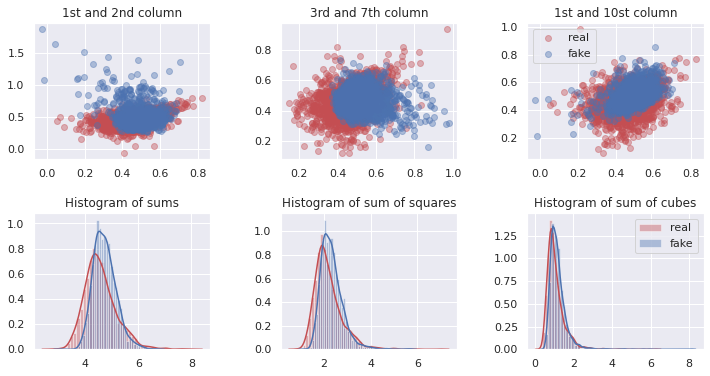

Epoch: 2500
log score: 8.37326966756097


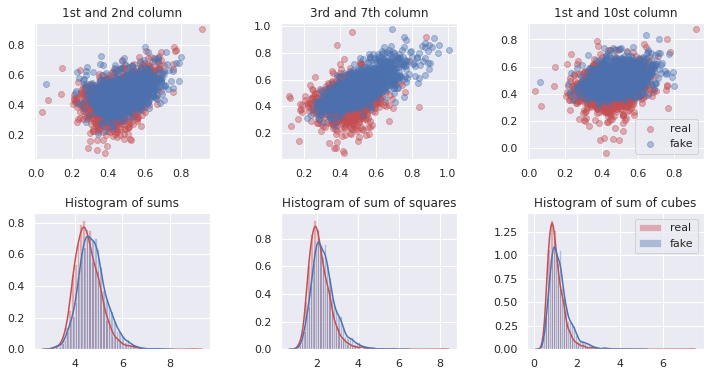

Epoch: 3000
log score: 10.657398862931512


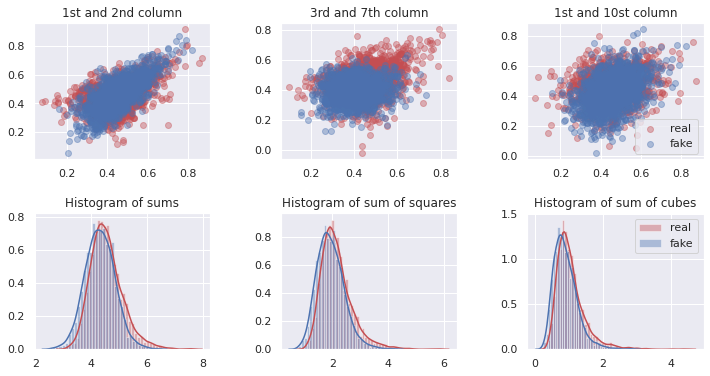

Epoch: 3500
log score: 8.464924302329038


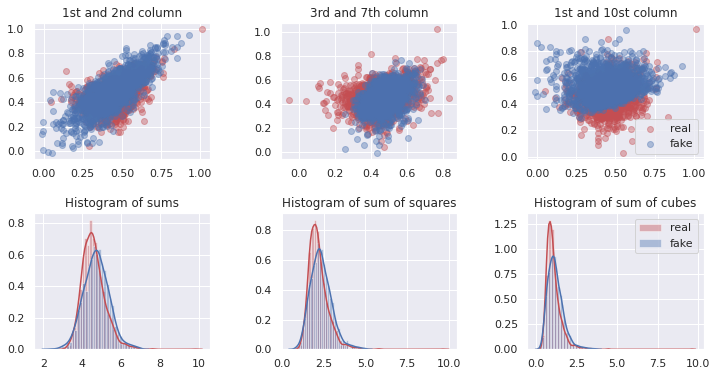

Epoch: 4000
log score: 7.3792710415739755


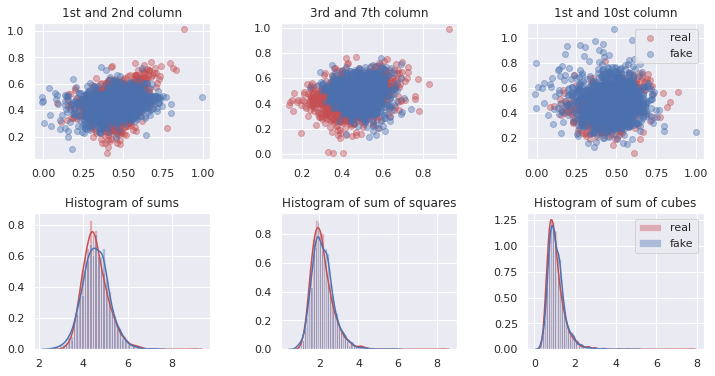

Epoch: 4500
log score: 11.064051147649357


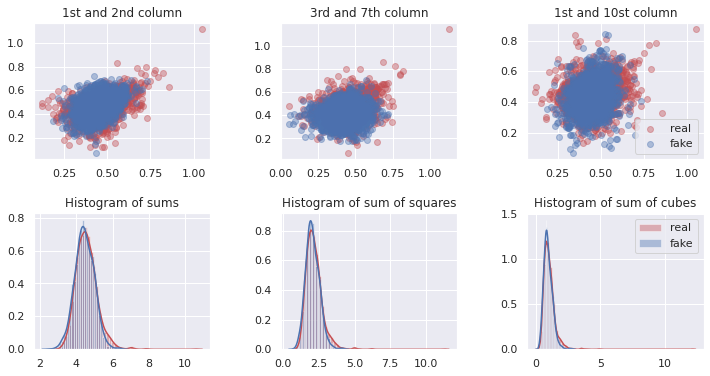

Epoch: 5000
log score: 10.874341402063486


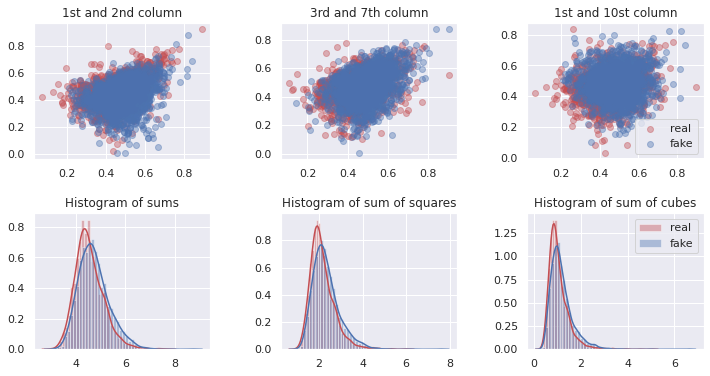

Epoch: 5500
log score: 11.122795615433885


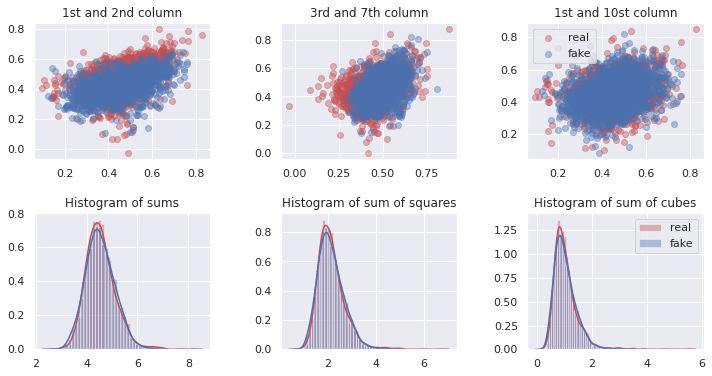

Epoch: 6000
log score: 11.030037040407535


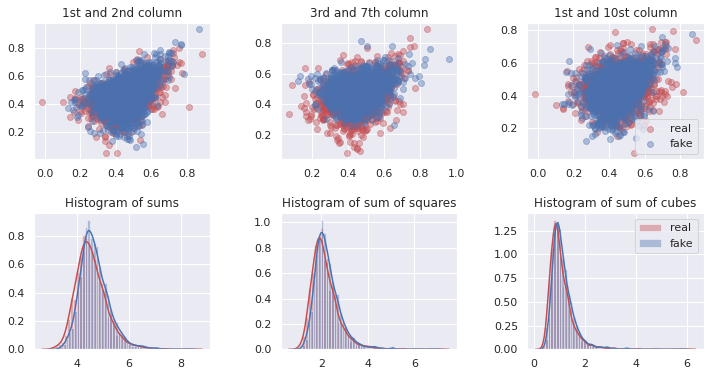

Epoch: 6500
log score: 10.512998082279415


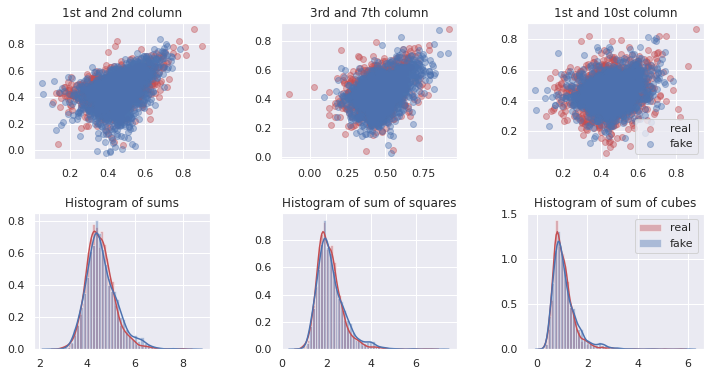

Epoch: 7000
log score: 10.750433854408918


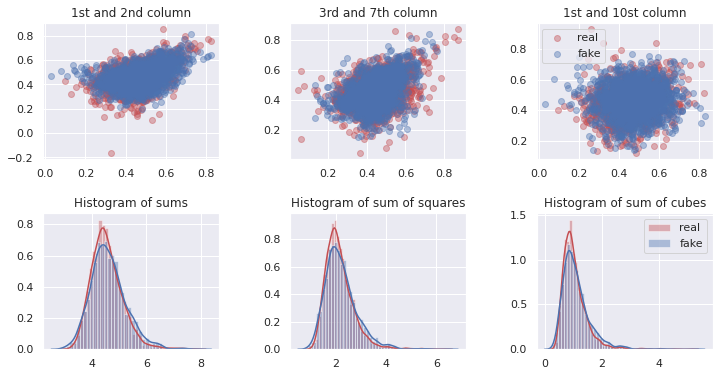

Epoch: 7500
log score: 11.522463722722163


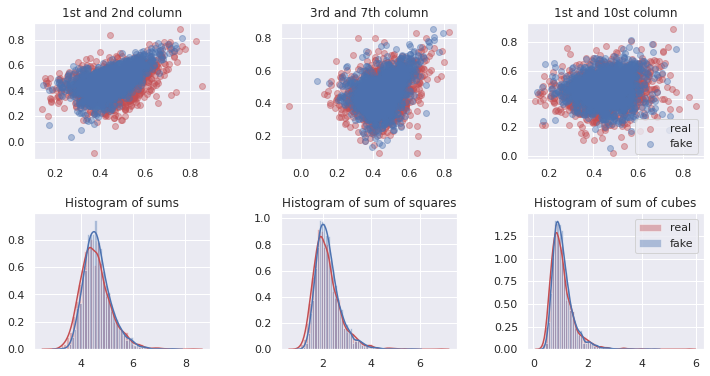

Epoch: 8000
log score: 10.63207905033351


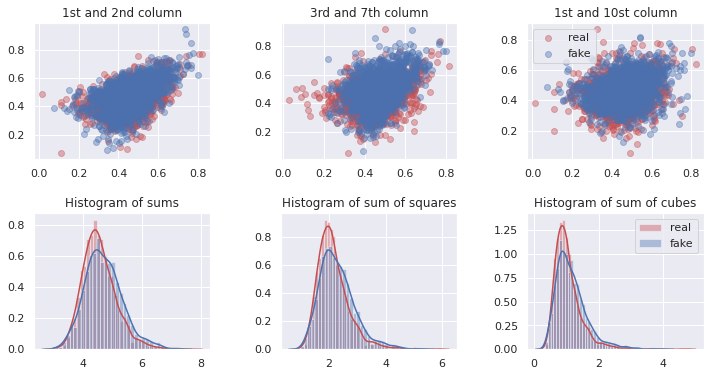

Epoch: 8500
log score: 10.409556567250087


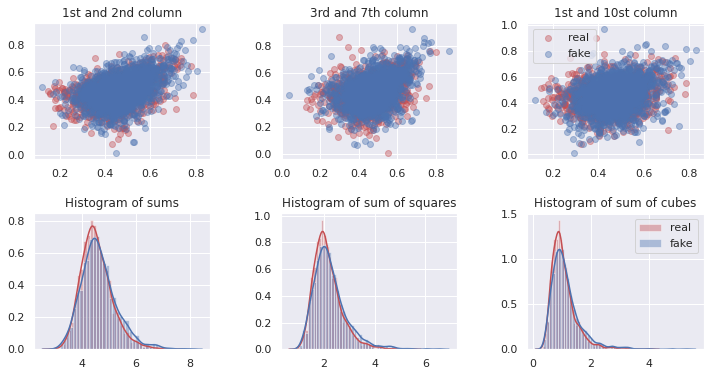

Epoch: 9000
log score: 10.862914881477293


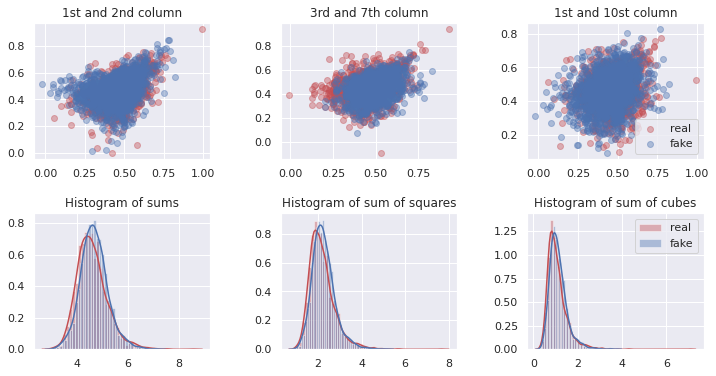

Epoch: 9500
log score: 11.055337618218221


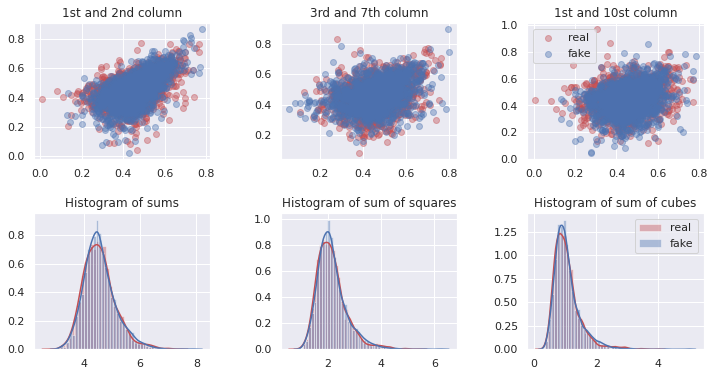

Epoch: 10000
log score: 11.215820798095134


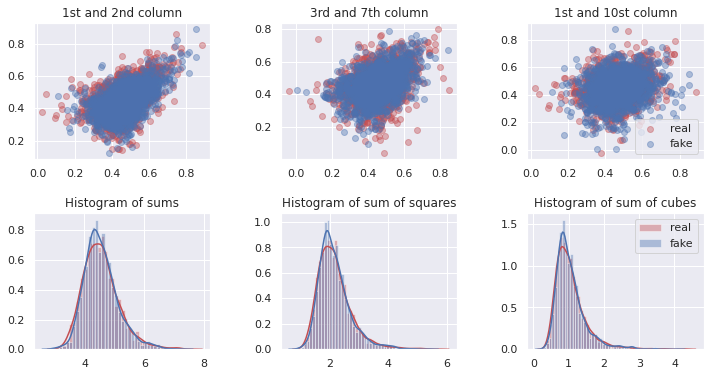

Epoch: 10500
log score: 11.040866947412333


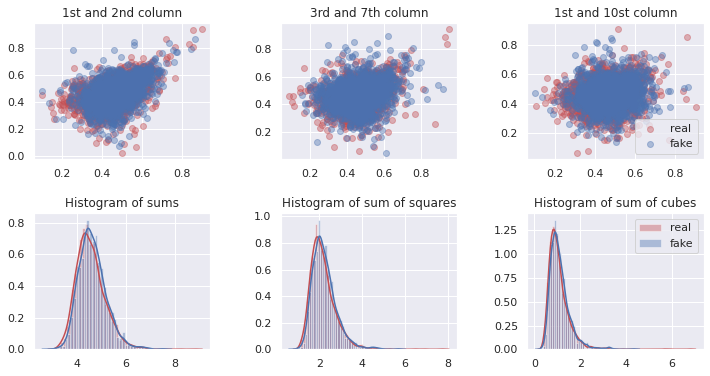

Epoch: 11000
log score: 10.507981485449731


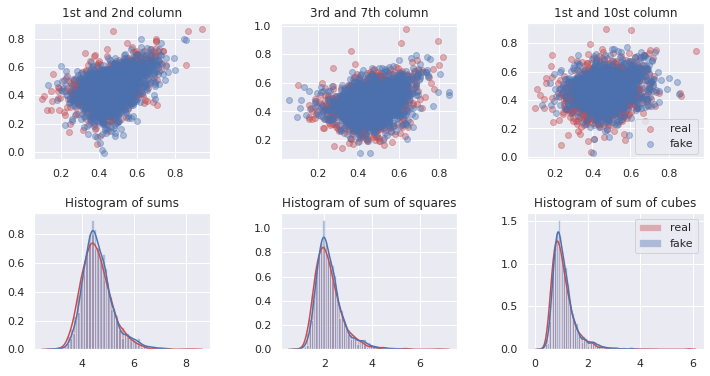

Epoch: 11500
log score: 11.412783750858404


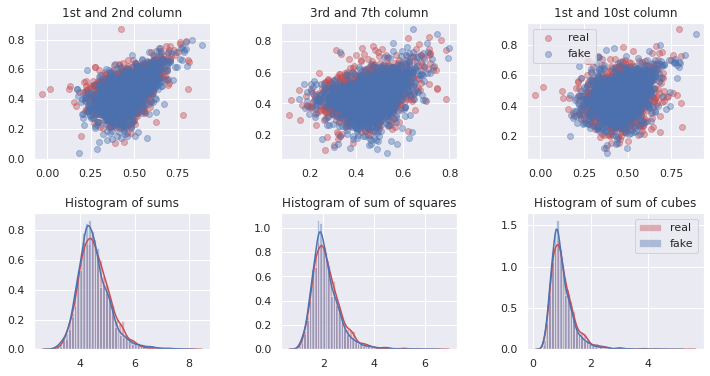

Epoch: 12000
log score: 11.246410478758193


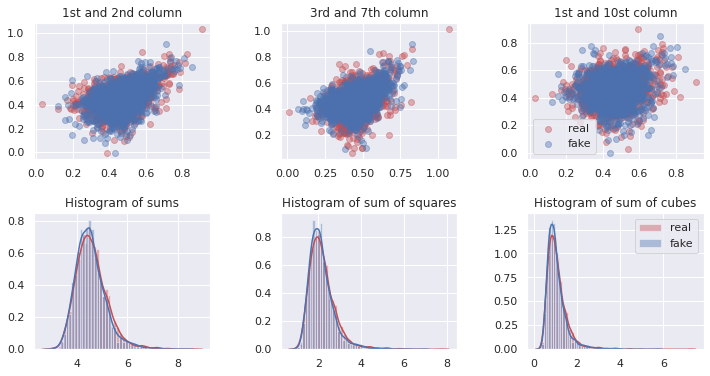

Epoch: 12500
log score: 10.983584545676303


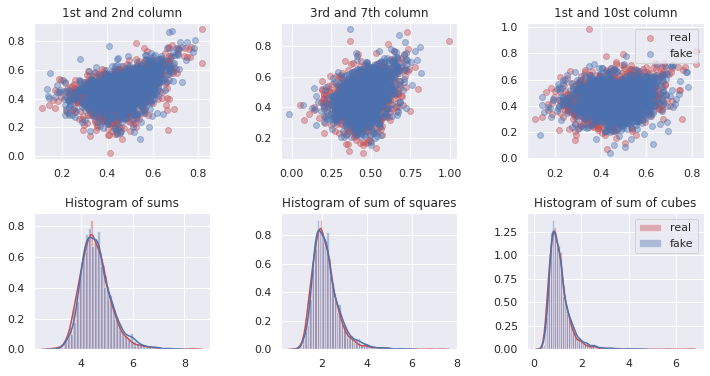

Epoch: 13000
log score: 11.121464904100256


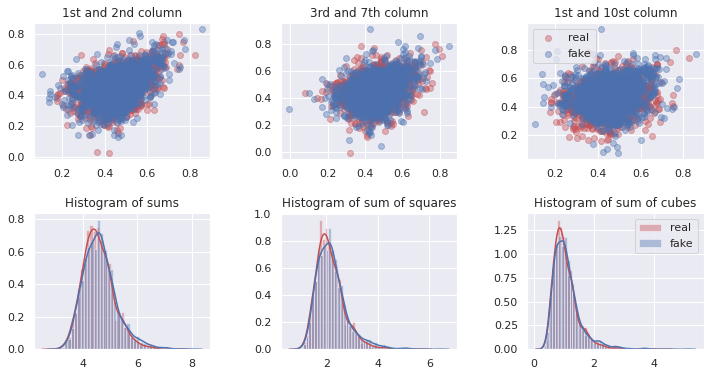

Epoch: 13500
log score: 10.98335228234345


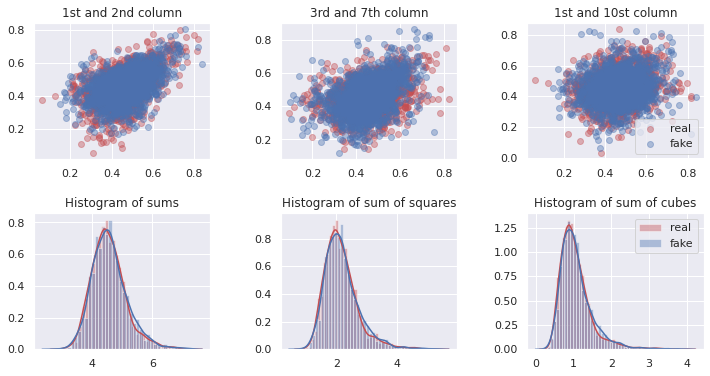

Epoch: 14000
log score: 11.232237641155825


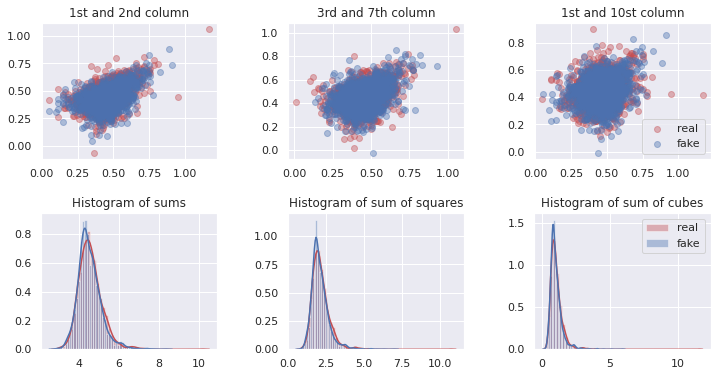

Epoch: 14500
log score: 11.348542410701386


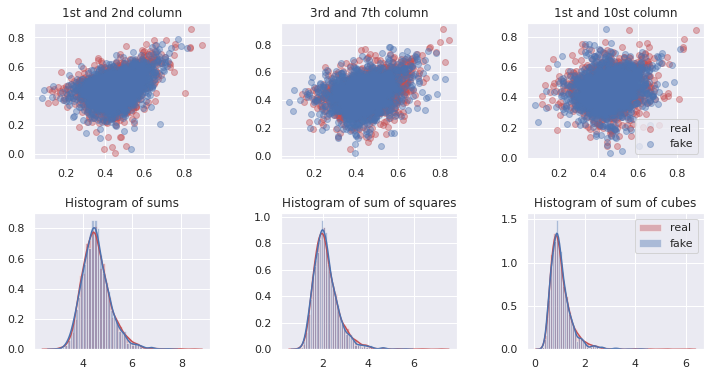

Epoch: 15000
log score: 10.962569108850188


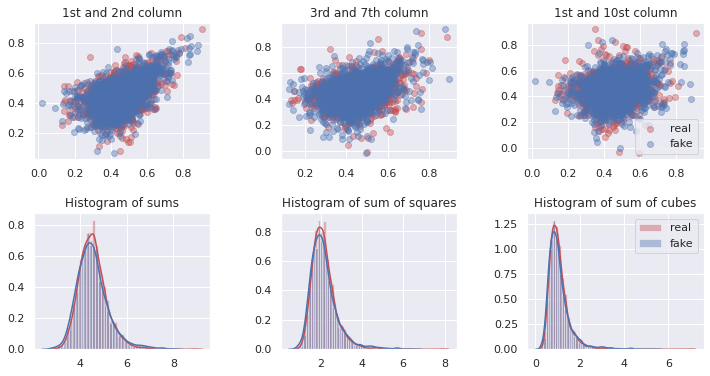

Epoch: 15500
log score: 11.115594315842117


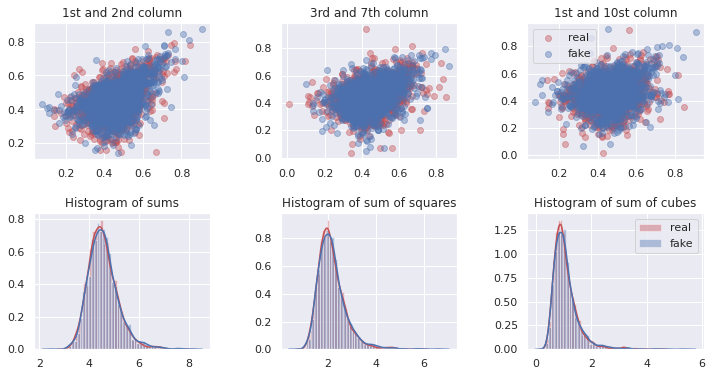

Epoch: 16000
log score: 11.409350938742186


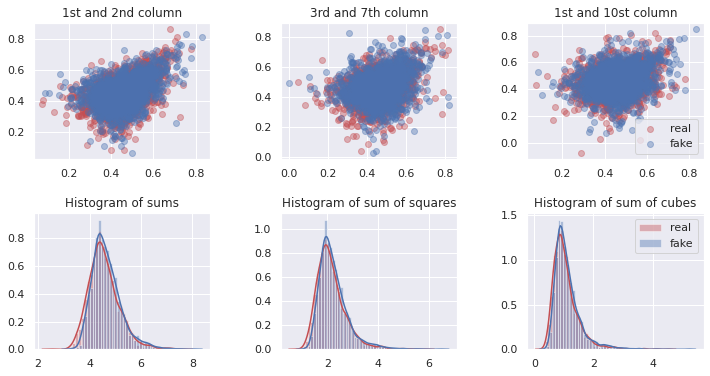

Epoch: 16500
log score: 11.130124291678646


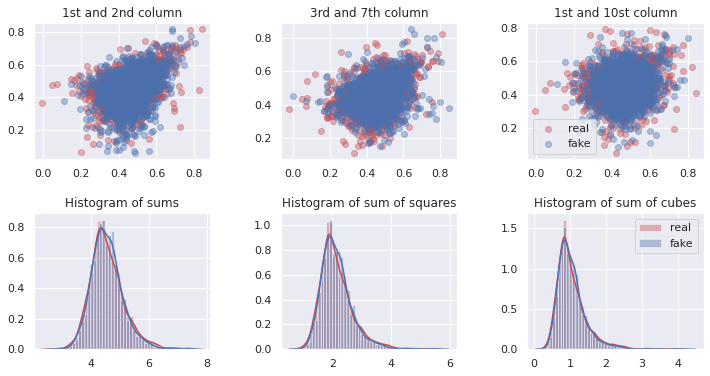

Epoch: 17000
log score: 10.942886683069775


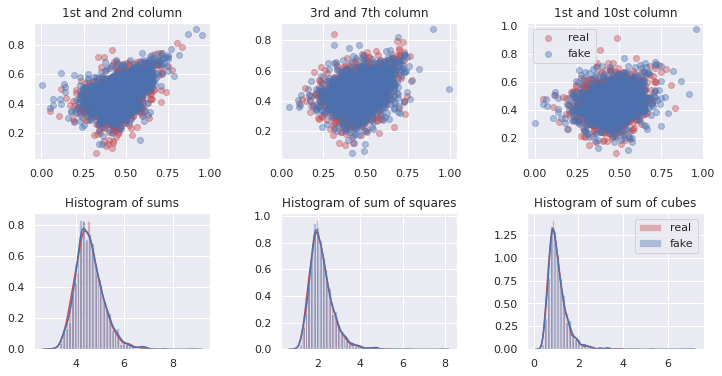

Epoch: 17500
log score: 11.082227391149294


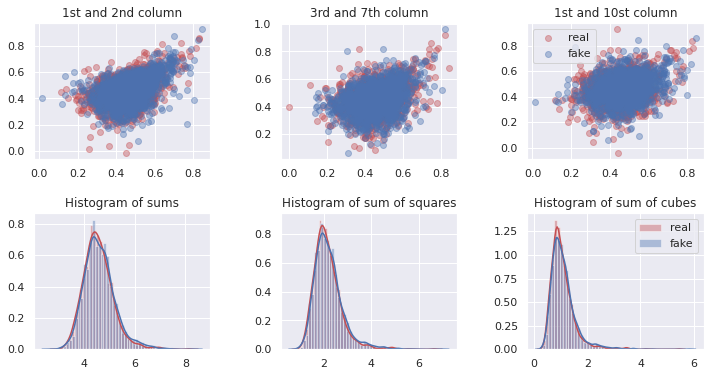

Epoch: 18000
log score: 11.286045978066197


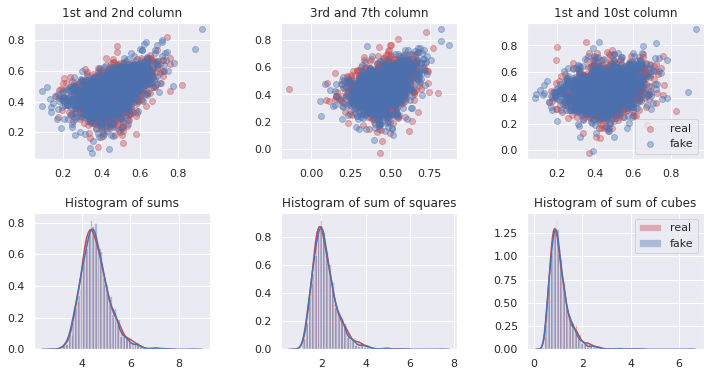

Epoch: 18500
log score: 10.935390923716964


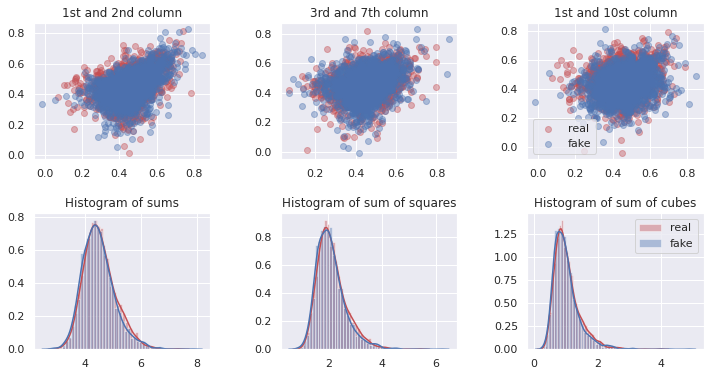

Epoch: 19000
log score: 11.20803313595235


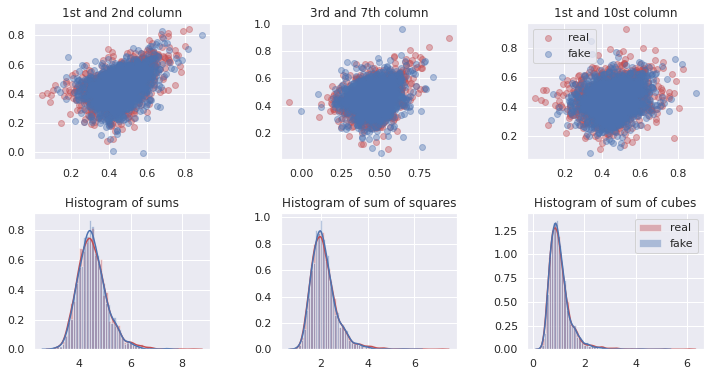

Epoch: 19500
log score: 11.35660034501531


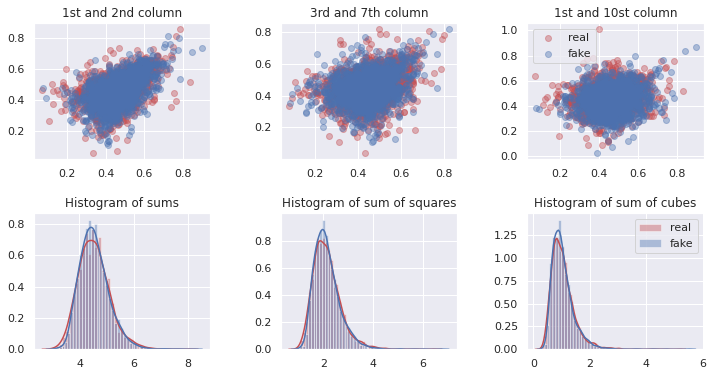

Epoch: 20000
log score: 11.17097097981451


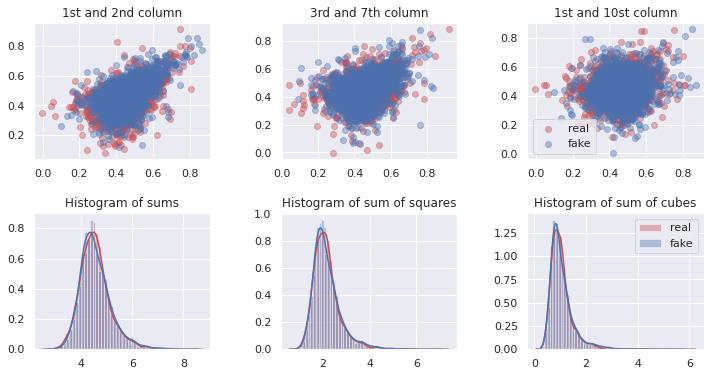

Epoch: 20500
log score: 11.272981792911104


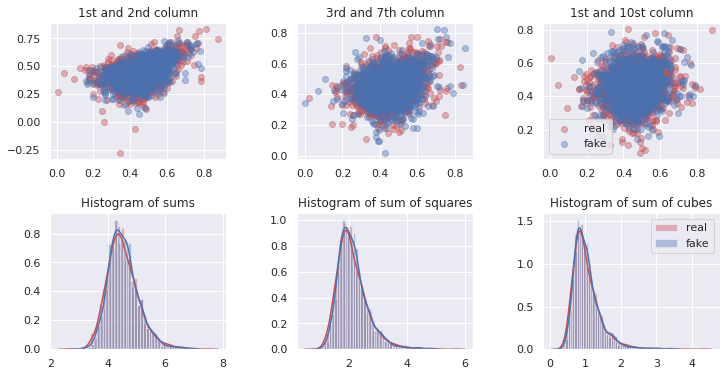

In [3]:
m1=[[],[]]
m2=[[],[]]
real_shuffle_acc=[[],[]]
fake_shuffle_acc=[[],[]]
g_loss=[[],[]]
d_loss=[[],[]]
score_list=[]

warnings.filterwarnings('ignore')

# define the standalone discriminator model
def define_discriminator():
    model = Sequential()
    model.add(Dense(100, input_shape=(1,10)))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(500))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(500))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = optimizers.RMSprop(lr=0.0001, decay=1e-6)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    model.add(Dense(100, input_shape=[latent_dim]))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(100))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(300))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(200))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dense(10))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Reshape((1,10)))
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    opt = optimizers.Adam(lr=0.00005, decay=1e-5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# generate n real samples with class labels
def generate_real_samples(n_samples):
    dataset = np.log(np.array([generate_gaps(10) for _ in range(n_samples)])) / 20    
    dataset = dataset.reshape(-1,1,10)
    y=ones((n_samples,1))
    return dataset, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=2000):
    # prepare real samples
    x_real, y_real = generate_real_samples(n)
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    
    x_fake = x_fake.reshape(n,10)
    x_real = x_real.reshape(n,10)

    fhat = stats.gaussian_kde(x_real.T, bw_method=None, weights=None)
    score = fhat.logpdf(x_fake.T)
    score_list.append(sum(score) / len(score))
    print("Epoch:",epoch)
    print('log score:',sum(score) / len(score))
    plt.figure(figsize=(12,6))
    plt.subplots_adjust(wspace = 0.4, hspace= 0.4)
    plt.subplot(2,3,1)
    plt.title('1st and 2nd column')
    plt.scatter(x_real[:,0],x_real[:,1],alpha=0.4,color='r', label='real')
    plt.scatter(x_fake[:,0],x_fake[:,1],alpha=0.4,color='b', label='fake')

    plt.subplot(2,3,2)
    plt.title('3rd and 7th column')
    plt.scatter(x_real[:,2],x_real[:,6],alpha=0.4,color='r', label='real')
    plt.scatter(x_fake[:,2],x_fake[:,6],alpha=0.4,color='b', label='fake')

    plt.subplot(2,3,3)
    plt.title('1st and 10st column')
    plt.scatter(x_real[:,0],x_real[:,9],alpha=0.4,color='r', label='real')
    plt.scatter(x_fake[:,0],x_fake[:,9],alpha=0.4,color='b', label='fake')
    plt.legend() 

    plt.subplot(2,3,4)
    plt.title("Histogram of sums")
    sns.distplot(np.sum(x_real,axis=1),color='r',label='real')
    sns.distplot(np.sum(x_fake,axis=1),color='b',label='fake')

    plt.subplot(2,3,5)
    plt.title("Histogram of sum of squares")
    sns.distplot(np.sum(np.square(x_real),axis=1),color='r',label='real')
    sns.distplot(np.sum(np.square(x_fake),axis=1),color='b',label='fake')
    
    plt.subplot(2,3,6)
    plt.title("Histogram of sum of cubes")
    sns.distplot(np.sum(np.power(x_real,3),axis=1),color='r',label='real')
    sns.distplot(np.sum(np.power(x_fake,3),axis=1),color='b',label='fake')
    plt.legend() 

    plt.show()
   

def smooth_positive_labels(y):
    return y - 0.3 + (random(y.shape) * 0.5)
def smooth_negative_labels(y):
    return y + 0.3 + (random(y.shape) * 0.3)


# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=21000, n_batch=256, n_eval=500):
    # determine half the size of one batch, for updating the discriminator
    bat_per_eop = int(5000 / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        for j in range(bat_per_eop):
            # prepare real samples
            x_real, y_real = generate_real_samples(half_batch)
            # prepare fake examples
            x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            y_real = smooth_positive_labels(y_real)
            y_fake = smooth_negative_labels(y_fake)
            # update discriminator
            loss_1=d_model.train_on_batch(x_real, y_real)
            loss_2=d_model.train_on_batch(x_fake, y_fake)
            # prepare points in latent space as input for the generator
            x_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            y_gan = smooth_positive_labels(y_gan)
            # update the generator via the discriminator's error
            loss_3=gan_model.train_on_batch(x_gan, y_gan)
            d_loss.append(loss_1[0]+loss_2[0])
            g_loss.append(loss_3)
            # evaluate the model every n_eval epochs
        if (i) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

# size of the latent space
latent_dim = 30
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)